# AGN Catalog Toolbox (ACT) Encapsulated Testing

This is an example notebook showing the AGN Catalog Toolbox Testing code (written by Chris) in action.

In [1]:
import ACTTestingEncapsulation as actt
import ACTLiterature as actl 
from AGNCatalogToolbox import edd_schechter_function
import AGNCatalogToolbox as ACT
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp


# Set the redshift of interest here.
redshift = 0

ModuleNotFoundError: No module named 'ACTTestingEncapsulation'

The variables we wish to test are listed in arrays for easy repeated access.

Next we create the class, and we call the approprate member functions to read in the data, assign the variables we want and then return the plotting data. Much of the best behaviour is encapsulated by the default arguments, so some parameters do not need to be called. Running this section can take some time.

Note that calling the member function to load in the multidark data expects a file in a subfolder '/BigData/' that is named 'MD_<redshift>.npy, in with the columns x, y, z, scale at accretion, mass at accretion, and mvir.

In [4]:
# Create the master class.
obj = actt.AGNCatalog()
obj.set_z(redshift)

# Load in the MultiDark Haloes.
obj.load_dm_catalog(path_big_data="./BigData/")
obj.assign_stellar_mass()#formula="Moster"
obj.assign_black_hole_mass()

Loading Dark Matter Catalog
Loading Halo Catalogue
('dtypes found: ', dtype([('row_id', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('rockstarId', '<i8'), ('upId', '<i8'), ('Mvir', '<f8'), ('First_Acc_Scale', '<f8'), ('First_Acc_Mvir', '<f8')]))
    Sorting list w.r.t. upId
    copying all 113798486 elements with up_id = -1
    sorting remaining list list w.r.t. main id
('    copying remaining', '16609467', 'elements')
Assigning Stellar Mass
Scatter is a thing, valued at 0.001
Assigning Black Hole Mass


### Example of catalog cut - reduce volume

In [5]:
flag = (obj.main_catalog['black_hole_mass'] >= 3.) 
black_hole_mass = obj.main_catalog['black_hole_mass'][flag]
stellar_mass = obj.main_catalog['stellar_mass'][flag]

In [198]:

l_edd = np.zeros(len(black_hole_mass))
l_edd = 38.1072 + black_hole_mass

edd_bin1 = np.arange(-4, 1, 0.0001)
parla = -0.5
paral = -0.5
prob_schechter_function = edd_schechter_function(10.**edd_bin1, method="Schechter", arg1=parla, arg2=paral,redshift_evolution=False, z=redshift)


p = prob_schechter_function * (10.**0.0001)

r_prob = p[::-1]
prob_cum = np.cumsum(r_prob)
r_prob_cum = prob_cum[::-1]
y1 = r_prob_cum / r_prob_cum[0]
y = y1[::-1]
edd_bin = edd_bin1[::-1]

a = np.random.random(len(black_hole_mass))
y2edd_bin = sp.interpolate.interp1d(y, edd_bin, bounds_error=False, fill_value=(edd_bin[0], edd_bin[-1]))
lg_edd = y2edd_bin(a)  

l_bol1 = np.zeros(len(l_edd))
l_bol1 = lg_edd + l_edd
lg_l_bol = l_bol1 - 33.49
lg_lum = lg_l_bol - 1.54 - (0.24 * (lg_l_bol - 12.)) - \
        (0.012 * ((lg_l_bol - 12.) ** 2.)) + (0.0015 * ((lg_l_bol - 12.) ** 3.))
luminosity = lg_lum + 33.49



In [199]:
print("U")
duty_cycle = ACT.to_duty_cycle("Man16", stellar_mass, black_hole_mass)

print("nh")
nh1 = ACT.luminosity_to_nh(luminosity, redshift)

U
nh


In [ ]:
flag = (luminosity>41.)*(nh1>=20)*(nh1<=24)#(black_hole_mass>=6)*(lg_edd >=-2)#(nh1>=20)*(nh1<=24)#
luminosityty12 = luminosity[flag]
eddty12 = lg_edd[flag]
stellar_massty12 = stellar_mass[flag]
BH_massty12 = black_hole_mass[flag]
duty_cyclety12 = duty_cycle[flag]
Nhty12 = nh1[flag]

In [20]:
BHmassbin = np.arange(6.,9.5,0.1)
U = np.ones(len(BHmassbin)-1)
bin1 = np.ones(len(BHmassbin)-1)

for i in range(len(BHmassbin)-1):
    N = np.where( (BH_massty12>=BHmassbin[i]) & (BH_massty12<BHmassbin[i+1]) )
    U[i] = np.sum(duty_cyclety12[N])/len(N[0])
    bin1[i] = (BHmassbin[i]+BHmassbin[i+1])/2.
    
    
#USch = sp.stats.binned_statistic(BH_massty12, duty_cyclety12, 'sum', bins=BHmassbin)[0] / len(BH_massty12)
#BHmassbin1 = BHmassbin[0:-1]
#np.savetxt('ConstU.txt',np.column_stack((bin1,U)))

#print USch, bin1

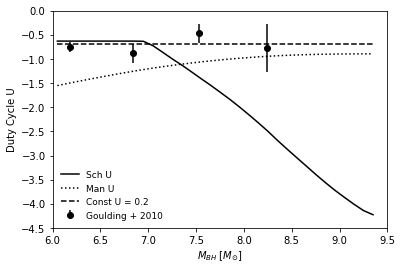

In [25]:
plt.figure()

BHMan, dcMan = np.loadtxt('./ManU.txt',skiprows=0,usecols=(0,1),unpack=True)
BHSch, USch = np.loadtxt('./SchU.txt',skiprows=0,usecols=(0,1),unpack=True)


GouBH, UGou, errGou = np.loadtxt('./Data/Goulding.txt',skiprows=0,usecols=(0,1,2),unpack=True)


Uconst = np.ones(len(bin1))*0.2
plt.plot(BHSch, np.log10(USch), "k",linestyle='-',label = "Sch U")
plt.plot(BHMan, np.log10(dcMan), "k",linestyle=':',label = "Man U")
plt.plot(BHSch, np.log10(Uconst), "k",linestyle='--',label = "Const U = 0.2")
plt.errorbar(GouBH, np.log10(UGou),yerr= errGou, fmt='o', color='black',label = "Goulding + 2010")




plt.xlabel(r'$M_{BH}\;[M_{\odot}]$')
plt.ylabel(r'Duty Cycle U')

plt.axis([6, 9.5, -4.5,0])
plt.legend(loc='lower left',frameon=False, fontsize = 9)

plt.savefig("./outputsplotz/SchManConstGouU.png", dpi=400)


plt.show()


In [8]:
import scipy as sp

volume = (1000./obj.h)**3.
step = 0.1
bins = np.arange(8., 12.5, step)
#mass_bins = sp.stats.binned_statistic(stellar_massty12, duty_cyclety12, 'sum', bins=bins)[0]
#mass_func = (mass_bins/volume)/step
#lum1 = np.log10(mass_bins[mass_bins > 0])
mass_funcAGN = np.ones(len(bins)-1)
mass_func = np.ones(len(bins)-1)
mass_func1 = np.ones(len(bins)-1)



for i in range(len(bins)-1):
    N = np.where( (stellar_massty12>=bins[i]) & (stellar_massty12<bins[i+1]))
    N1 = np.where( (stellar_mass>=bins[i]) & (stellar_mass<bins[i+1]))
    mass_funcAGN[i] = (np.sum(duty_cyclety12[N])/volume)/step
    mass_func[i] = (len(N1[0])/volume)/step
    mass_func1[i] = (len(N[0])/volume)/step

bins1 = bins[0:-1]


#np.savetxt('./outputs/actSMFSchULx.txt',np.column_stack((bins1,mass_funcAGN)))
#np.savetxt('./outputs/totalSMFLx.txt',np.column_stack((bins1,mass_func1)))
#np.savetxt('./outputs/totalSMF.txt',np.column_stack((bins1,mass_func)))





/Users/allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


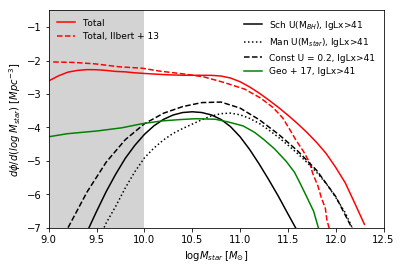

In [49]:
fbk = {'lw':0.0, 'edgecolor':None}


BHMan, phiMan = np.loadtxt('./outputs/actSMFConstULx.txt',skiprows=0,usecols=(0,1),unpack=True)
BHSch, phiSch = np.loadtxt('./outputs/actSMFSchULx.txt',skiprows=0,usecols=(0,1),unpack=True)

BHIlb, phiIlb = np.loadtxt('./Data/SMFIlb13.csv',skiprows=0,usecols=(0,1),unpack=True,delimiter=',')
BHGeo, phiGeo = np.loadtxt('./Data/SMFGeo17.txt',skiprows=0,usecols=(0,1),unpack=True)




plt.figure()
line1, = plt.plot(bins1, np.log10(mass_func), "r", linestyle = "-", label = "Total")
#plt.plot(bins1, np.log10(mass_func1), "r", linestyle = ":", label = "Total, lgLx>41")
line2, =plt.plot(BHIlb, (phiIlb), "r", linestyle = "--", label = "Total, Ilbert + 13")

first_legend = plt.legend(handles=[line1,line2], loc='upper left',frameon=False, fontsize = 9)
ax = plt.gca().add_artist(first_legend)

line3, =plt.plot(BHSch, np.log10(phiSch), "k", linestyle = "-", label = "Sch U(M$_{BH}$), lgLx>41")
line4, =plt.plot(bins1, np.log10(mass_funcAGN), "k", linestyle = ":", label = "Man U(M$_{star}$), lgLx>41")
line5, =plt.plot(BHMan, np.log10(phiMan), "k", linestyle = "--", label = "Const U = 0.2, lgLx>41")


line6, =plt.plot(BHGeo, phiGeo, "g", linestyle = "-", label = "Geo + 17, lgLx>41")

phi = np.arange(-7,0.4,0.2)
M1 = np.ones(len(phi))*9.
M2 = np.ones(len(phi))*10.


plt.fill_betweenx(phi,M1,M2,facecolor='lightgrey',**fbk)



#plt.plot(bins1, mass_func, "r", linestyle = "-", label = "S Model, Geo U(M$_{star}$)")


plt.xlabel(r'log$M_{star}\;[M_{\odot}]$')
plt.ylabel(r'$d\phi /d(log\;M_{star})\;[Mpc^{-3}]$')

plt.axis([9, 12.5, -7,-0.5])
plt.legend(handles=[line3,line4,line5,line6],loc='upper right',frameon=False, fontsize = 9)
#plt.text(12.8,-6.5, "K&H",fontsize = 11)


plt.savefig("./outputsplotz/totalactSMFSchManConstU.png", dpi=400)
plt.show()

In [9]:

import scipy as sp

volume = (1000./obj.h)**3.
step = 0.2
bins = np.arange(3., 11., step)
BHmass_funcAGN = np.ones(len(bins)-1)
BHmass_funcAGN1 = np.ones(len(bins)-1)
BHmass_func = np.ones(len(bins)-1)
BHmass_func1 = np.ones(len(bins)-1)

ty1 = np.where( (nh1 > 20) & (nh1 <= 22) )
BH_massty1 = black_hole_mass[ty1]
duty_cyclety1 = duty_cycle[ty1]
               
for i in range(len(bins)-1):
    N = np.where( (BH_massty12>=bins[i]) & (BH_massty12<bins[i+1]))
    N1 = np.where( (black_hole_mass>=bins[i]) & (black_hole_mass<bins[i+1]))
    N2 = np.where( (BH_massty1>=bins[i]) & (BH_massty1<bins[i+1]))


    BHmass_funcAGN[i] = (np.sum(duty_cyclety12[N])/volume)/step
    BHmass_funcAGN1[i] = (np.sum(duty_cyclety1[N2])/volume)/step
    BHmass_func[i] = (len(N[0])/volume)/step
    BHmass_func1[i] = (len(N1[0])/volume)/step

bins1 = bins[0:-1]


#np.savetxt('./outputs/actBHMFSchULx.txt',np.column_stack((bins1,BHmass_funcAGN)))
#np.savetxt('./outputs/totalBHMF.txt',np.column_stack((bins1,BHmass_func1)))
#np.savetxt('./outputs/totalBHMFLx.txt',np.column_stack((bins1,BHmass_func)))





In [10]:
BHShaup, phiShaup = np.loadtxt('./Data/Shankar19up.csv',skiprows=0,usecols=(0,1),unpack=True,delimiter=",")
BHShadw, phiShadw = np.loadtxt('./Data/Shankar19dw.csv',skiprows=0,usecols=(0,1),unpack=True,delimiter=",")

interpfunc19up = np.ones(len(BHShaup))
interpfunc19dw = np.ones(len(BHShadw))

interpfunc19up = sp.interpolate.interp1d(BHShaup,phiShaup, bounds_error=False,
                                            fill_value=(phiShaup[0], phiShaup[-1]),kind='linear')
interpfunc19dw = sp.interpolate.interp1d(BHShadw,phiShadw, bounds_error=False,
                                            fill_value=(phiShadw[0], phiShadw[-1]),kind='linear')



lgMbhbin = np.arange(5.8,9.5,0.1)

phimod19up = np.ones(len(lgMbhbin))
phimod19dw = np.ones(len(lgMbhbin))

phimod19up = interpfunc19up(lgMbhbin)
phimod19dw =  interpfunc19dw(lgMbhbin)



/Users/allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/Users/allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/allevato/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


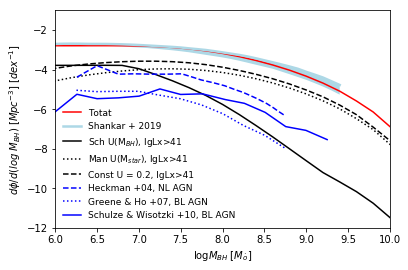

In [15]:
fbk = {'lw':0.0, 'edgecolor':None}





BHMan, phiMan = np.loadtxt('./outputs/actBHMFConstULx.txt',skiprows=0,usecols=(0,1),unpack=True)
BHSch, phiSch = np.loadtxt('./outputs/actBHMFSchULx.txt',skiprows=0,usecols=(0,1),unpack=True)
BHHec, phiHec = np.loadtxt('./Data/Heckman04.csv',skiprows=0,usecols=(0,1),unpack=True,delimiter = ",")
BHGH, phiGH = np.loadtxt('./Data/GreeneHo07.csv',skiprows=0,usecols=(0,1),unpack=True,delimiter = ",")
BHSW, phiSW = np.loadtxt('./Data/SchW10.csv',skiprows=0,usecols=(0,1),unpack=True,delimiter = ",")





plt.figure()


plt.plot(bins1, np.log10(BHmass_func1), "r", linestyle = "-", label = "Totat")
#plt.plot(bins1, np.log10(BHmass_func), "r", linestyle = ":", label = "Totat, lgLx>41")


plt.fill_between(lgMbhbin,phimod19up,phimod19dw,facecolor='lightblue',**fbk)
plt.plot(lgMbhbin,phimod19up,color='lightblue',linewidth=2.5,label='Shankar + 2019')
#plt.fill_between(lgMbhbin09,phimod09dw,phimod09up,facecolor='Silver',**fbk)
#plt.plot(lgMbhbin09,phimod09dw,color='silver',linewidth=2.5,label='Shankar + 2009')
#plt.plot(tM.MBH,tM.phiBH,color='green',linewidth=2.5,label='Marconi + 2004')

plt.plot(BHSch, np.log10(phiSch), "k", linestyle = "-", label = "Sch U(M$_{BH}$), lgLx>41")
plt.plot(bins1, np.log10(BHmass_funcAGN), "k", linestyle = ":", label = "Man U(M$_{star}$), lgLx>41")
plt.plot(BHMan, np.log10(phiMan), "k", linestyle = "--", label = "Const U = 0.2, lgLx>41")

plt.plot(BHHec, (phiHec), "b", linestyle = "--", label = "Heckman +04, NL AGN")
plt.plot(BHGH, (phiGH), "b", linestyle = ":", label = "Greene & Ho +07, BL AGN")
plt.plot(BHSW, (phiSW), "b", linestyle = "-", label = "Schulze & Wisotzki +10, BL AGN")






plt.xlabel(r'log$M_{BH}\;[M_{\doto}]$')
plt.ylabel(r'$d\phi /d(log\;M_{BH})\;[Mpc^{-3}]\;[dex^{-1}] $')

plt.axis([6, 10., -12,-1])
plt.legend(loc='lower left',frameon=False, fontsize = 9)
#plt.text(6.2,-2.3, "K&H",fontsize = 11)


plt.savefig("./outputsplotz/actBHMFSchManConstLxa.png", dpi=400)
plt.show()



In [ ]:
import scipy as sp

volume = (1000./obj.h)**3.
step = 0.2
bins = np.arange(42., 45., step)
lum_bins = sp.stats.binned_statistic(luminosityty12, duty_cyclety12, 'sum', bins=bins)[0]
lum_func = (lum_bins/volume)/step
bins1 = bins[0:-1][lum_func > 0]
lum1 = np.log10(lum_func[lum_func > 0])

#np.savetxt('XLFAGNplotz0SModelConstU.txt',np.column_stack((bins1,lum1)))

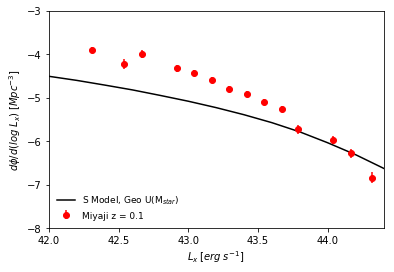

In [201]:


#LxConst, phiLxConst = np.loadtxt('./XLFAGNplotz0SModelConstU.txt',skiprows=0,usecols=(0,1),unpack=True)
#LxMan, phiLxMan = np.loadtxt('./XLFAGNplotz0SModelManU.txt',skiprows=0,usecols=(0,1),unpack=True)




plt.figure()
plt.plot(bins1, lum1, "k", linestyle = "-", label = "S Model, Geo U(M$_{star}$)")



#plt.plot(LxSch, phiLxSch, "k", linestyle = "-", label = "S Model, Sch U(M$_{BH}$)") 
#plt.plot(LxMan, phiLxMan, "k", linestyle = ":", label = "S Model, Man U(M$_{star}$)")  
#plt.plot(LxConst, phiLxConst, "k", linestyle = "--", label = "S Model, Const U = 0.2")    



fbk = {'lw':0.0, 'edgecolor':None}

LxM, phiM, errM = np.loadtxt('./Data/Miyaji2015_z0.1.txt',skiprows=0,usecols=(0,1,2),unpack=True)
err = np.log10(phiM + errM)-np.log10(phiM)
plt.errorbar(LxM, np.log10(phiM),yerr=err, fmt='o', color='red',label = "Miyaji z = 0.1")
XLF1 = actl.XLFData(1.)
mXLF_data1 = XLF1.get_miyaji2015()
plt.xlabel(r'$L_x\;[erg\;s^{-1}]$')
plt.ylabel(r'$d\phi /d(log\;L_x)\;[Mpc^{-3}]$')

plt.axis([42, 44.4, -8,-3])
plt.legend(loc='lower left',frameon=False, fontsize = 9)

#plt.savefig("./plotz0/XLFSModelSchManConstU.png", dpi=400)
plt.show()

In [117]:
BHAR = np.arange(32,34.,0.1)
edd = (10.**BHAR)*( (500.*25.)/1.3e38 )
gamma = 0.96
A = 10. ** (29.50)
prob = A*((10.**BHAR ) ** -gamma)
prob = prob*0.1

edd1 = np.arange(-4,1,0.1)
AA = 10.**(-3.15)
gammaE = -0.65
gammaz = 3.47
z0 = 0.6
prob1 = (AA*((10.**edd1)**gammaE)*((1.+0.1)/(1.+z0))**gammaz)

In [118]:
eddBon16, phieddBon16a = np.loadtxt('./Data/sardf_ho_mc.txt',skiprows=0,usecols=(0,4),unpack=True)

phiBon16a = np.log10(((10.**phieddBon16a)/np.sum(10.**phieddBon16a)*(10.**0.01)))
phiBon16 = np.log10((10.**phiBon16a))


In [148]:
step = 0.1


lg_edd_derived = luminosityty12 - (stellar_massty12-0.15)  # log10(1.26e38 * 0.002) = 35.3802
    
edd_bin = np.arange(30,36.5, step)

prob_derived = sp.stats.binned_statistic(lg_edd_derived, duty_cyclety12, 'sum', bins=edd_bin)[0] / (sum(duty_cyclety12))*step

edd_bin = edd_bin[:-1]
edd_bin = edd_bin[prob_derived > 0]
prob_derived = prob_derived[prob_derived > 0]

np.savetxt('./outputs/ERDAGNplotz0SModelSchU.txt',np.column_stack((edd_bin,prob_derived)))



Warning - we have requested redshift 0 - Selecting file Geo17z0.25.csv as it is closest
Warning - we have requested redshift 0 - Selecting file Bon16z0.25.csv as it is closest
Warning - we have requested redshift 0 - Selecting file Bon12z0.25.csv as it is closest
Warning - we have requested redshift 0 - Selecting file Aird12z0.25.csv as it is closest


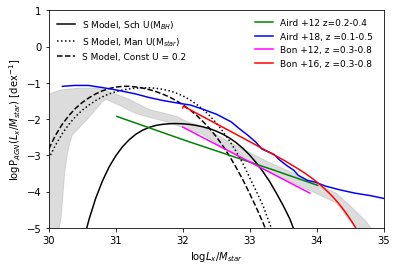

In [151]:

#np.savetxt('/outputs/ERDAGNplotz0SModelSchU.txt',np.column_stack((edd_bin,prob_derived)))

eddConst, phieddConst = np.loadtxt('./outputs/ERDAGNplotz0SModelConstU.txt',skiprows=0,usecols=(0,1),unpack=True)
eddMan, phieddMan = np.loadtxt('./outputs/ERDAGNplotz0SModelManU.txt',skiprows=0,usecols=(0,1),unpack=True)

eddAird18, phieddAird18 = np.loadtxt('./Data/Aird2018.csv',skiprows=0,usecols=(0,1),unpack=True,delimiter=',')




plt.figure()
flag = (edd_bin>32.)
line1, = plt.plot(edd_bin, np.log10(prob_derived), "k", linestyle = "-", label = "S Model, Sch U(M$_{BH}$)")


#plt.plot(eddSch, np.log10(phieddSch), "k", linestyle = "-", label = "S Model, Sch U(M$_{BH}$)")   
line2, = plt.plot(eddMan, np.log10(phieddMan), "k", linestyle = ":", label = "S Model, Man U(M$_{star}$)")    
line3, =plt.plot(eddConst, np.log10(phieddConst), "k", linestyle = "--", label = "S Model, Const U = 0.2")    


first_legend = plt.legend(handles=[line1,line2,line3], loc='upper left',frameon=False, fontsize = 9)
ax = plt.gca().add_artist(first_legend)



EddData = actl.EddingtonDistributionData(redshift)
#plt.plot(EddData.Geo.x, EddData.Geo.y, label = "Geo")

BHARGeo = (10.**EddData.Geo.x)/( (500.*25.)/1.3e38 )
plt.fill_between(np.log10(BHARGeo), EddData.Geo.yu, EddData.Geo.yd, color="darkgrey",alpha=0.4, label = "Geo +16, z=0.25")

BHARAird = (10.**EddData.Aird12.x)/( (500.*25.)/1.3e38 )
BHARAird18 = (10.**eddAird18)/( (500.*25.)/1.3e38 )


line4, = plt.plot(np.log10(BHARAird), EddData.Aird12.y,color="green", label = "Aird +12 z=0.2-0.4")
line6, =plt.plot(np.log10(BHARAird18), np.log10(phieddAird18),color="blue", label = "Aird +18, z =0.1-0.5 ")


line5, = plt.plot((BHAR), np.log10(prob),color="magenta", label = "Bon +12, z =0.3-0.8 ")


#BHARBon16 = (10.**EddData.Bon16.x)/( (500.*25.)/1.3e38 )


line7, =plt.plot(eddBon16, (phiBon16),color="red", label = "Bon +16, z =0.3-0.8".format(EddData.Bon16.z)) 
#plt.plot(EddData.Bon12.x, EddData.Bon12.y,color="magenta", label = "Bon +12, z =0.3-0.8 ")
#plt.plot(EddData.Aird12.x, EddData.Aird12.y,color="green", label = "Aird +12 z=0.2-0.4")

#plt.plot(np.log10(edd), np.log10(prob),color="magenta")
#plt.plot(edd1, np.log10(prob1),color="black", label = "Aird +12 ")

plt.legend(handles=[line4,line6,line5,line7],loc='upper right',frameon=False, fontsize = 9)



eddbin = np.arange(-4, 1., 0.5)
probSche = EddData.AirdDist(eddbin)
#plt.plot(eddbin, probSche, label = "Aird ?(analytic)")
#plt.title(r'Eddington Ratio Distribution, U=Schulze,$\alpha$=-0.25, z=0', fontname = 'Times New Roman')
plt.xlabel("log$L_x/M_{star}$")
plt.ylabel("logP$_{AGN}$($L_x/M_{star}$) [dex$^{-1}$]")

plt.xlim((30, 35.))
plt.ylim((-5., 1.))

#plt.legend(loc='upper right',frameon=False, fontsize = 9)
#plt.text(-3.8, 1, "K&H",fontsize = 11)



#plt.savefig("./plotz0/ERDSModelSchManConstU.png", dpi=400)
#plt.savefig("./plotz0/ERD.png", dpi=400)


plt.show()



In [ ]:
np.savetxt('Schulze_0.1.csv',np.column_stack((black_hole_mass,U1)),delimiter=',')
np.savetxt('Mann.csv',np.column_stack((black_hole_mass,U)),delimiter=',')




### XLF

### Eddington Ratio Distribution

### WP

### Bias

### HOD